In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import os
data_dir = os.path.expanduser("data/cora")

In [2]:
edgelist = pd.read_csv(os.path.join(data_dir, "cora.cites"), sep='\t', header=None, names=["target", "source"])
edgelist["label"] = "cites"

In [3]:
edgelist.sample(frac=1).head(10)

,target,source,label
5304,662250,1132073,cites
5130,626574,1154012,cites
2397,23116,1111978,cites
4204,137380,1108728,cites
4299,153063,561581,cites
509,1786,35797,cites
1044,4584,628815,cites
2545,27612,12198,cites
2572,27895,1132706,cites
5043,578650,1128291,cites


In [4]:
G = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(G, "paper", "label")

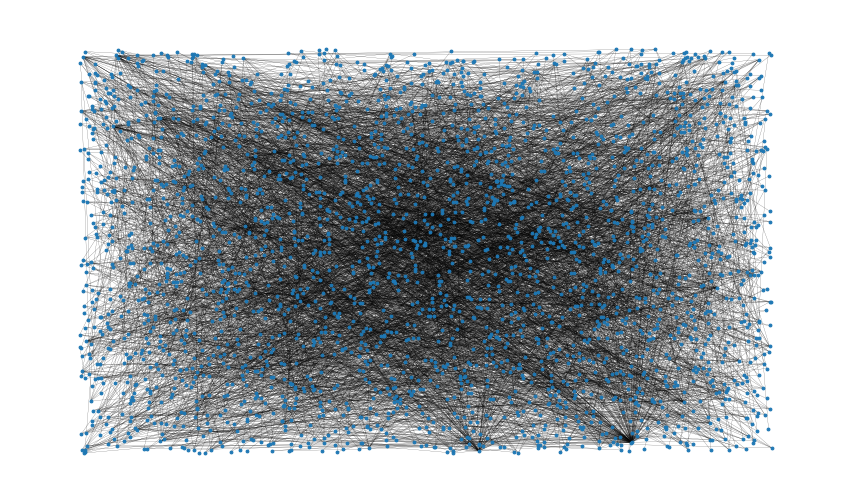

In [5]:
# 使用random layout 可视化数据，这是布局最快的函数但是难以观察数据的结构
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_settings = {"node_size": 8,  "width": 0.15, "with_labels": False}
alpha = 0.5
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_settings)

使用spring_layout函数，spring_layout函数是networkx绘图模块的默认布局函数。spring_layout会考虑节点和边来计算节点位置，比起random_layout,此函数更能够反应社交网络的结构。不过其计算时间也相对更多。

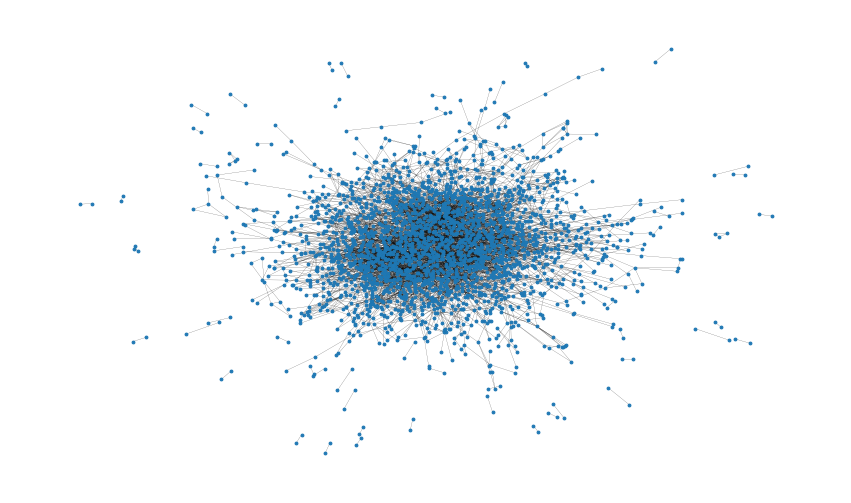

In [6]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_settings)

接下来我们可以看一些网络的基础信息，如：节点数量，连边数量等等。

In [7]:
nodes = G.number_of_nodes()# 节点数量
print("Number of nodes in the graph:", nodes)

Number of nodes in the graph: 2708


In [8]:
edges = G.number_of_edges()# 连边数量
print("Number of edges in the graph:", edges)

Number of edges in the graph: 5278


In [9]:
mean_degree = np.mean([degree for node, degree in G.degree()])
print("Mean degree of nodes in the graph:", mean_degree)

Mean degree of nodes in the graph: 3.8980797636632203


In [10]:
density = nx.density(G)
print("Density of graph:", density)

Density of graph: 0.0014399999126942077


In [11]:
if nx.is_connected(G):
    diameter = nx.diameter(G)
else:
    H = list(G.subgraph(c) for c in nx.connected_components(G))[0]
    diameter = nx.diameter(H)
print("The diameter of the graph:", diameter)

The diameter of the graph: 19


In [12]:
shortest_among_nodes = dict(nx.all_pairs_shortest_path_length(G))
# Compute the mean shortest path length for each node
# 这里的shortest_among_nodes记录了每个nodes到其他所有node所需要的最短路径
# 两次平均就可以求得任意两个nodes之间的平均距离
mean_len_each_node = [
    np.mean(tuple(anode.values())) for anode in shortest_among_nodes.values()
]
# The average over all nodes
mean_among_all_nodes = np.mean(mean_len_each_node)
print("The average length among all nodes is:", mean_among_all_nodes)

The average length among all nodes is: 5.871832035338443


<BarContainer object of 20 artists>

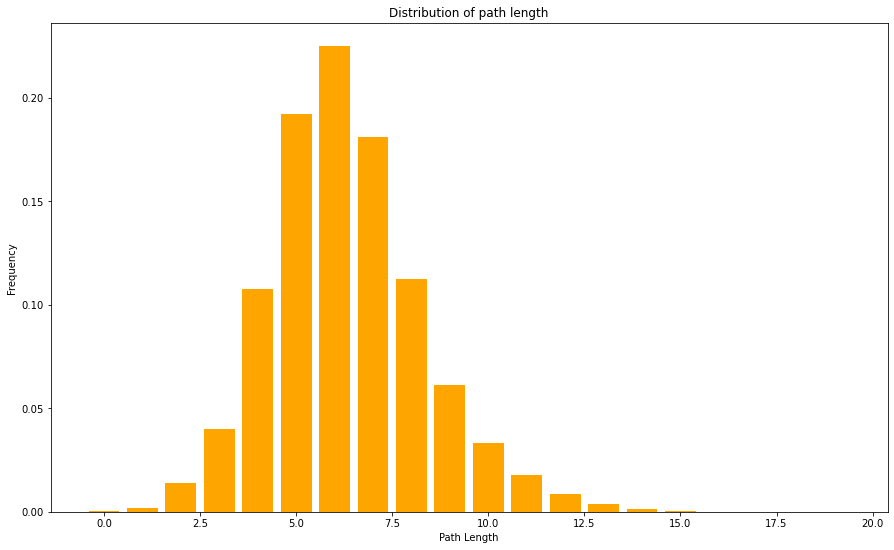

In [13]:
counts = np.zeros(diameter + 1, dtype=int)

for item in shortest_among_nodes.values():
    values_len = item.values()
    index, times = np.unique(list(values_len), return_counts=True)
    counts[index] += times

fre_counts = counts/np.sum(counts)
fig,ax = plt.subplots(figsize=(15,9))
ax.set_title("Distribution of path length")
ax.set_xlabel("Path Length")
ax.set_ylabel("Frequency")
ax.bar(np.arange(0, diameter+1), height = fre_counts,color = 'orange')

## 接下来我们进行一些关于度中心性的计算
### 1.首先是degree centrality

In [14]:
degree = nx.centrality.degree_centrality(G)  
degree_10 = (sorted(degree.items(), key=lambda x: x[1], reverse=True))[:10]
print("Max 10:\n", degree_10)

Max 10:
 [(35, 0.062061322497229406), (6213, 0.028814185445142224), (1365, 0.027336534909493903), (3229, 0.024011821204285185), (910, 0.01625415589213151), (114, 0.015515330624307351), (4330, 0.014776505356483192), (3231, 0.013298854820834873), (1272, 0.012560029553010712), (19621, 0.012190616919098634)]


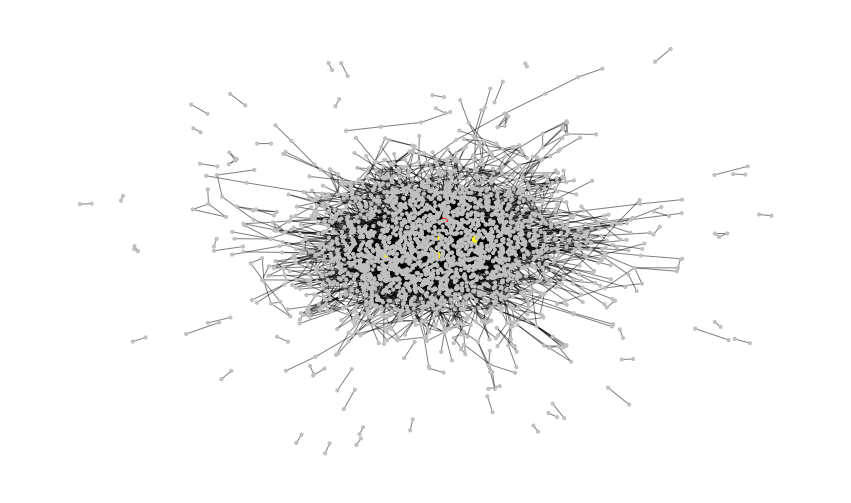

In [15]:
# 可视化
max_degree = max(np.max(degree.values()))
highlight = []
nodes_size = []
for key, value in degree.items():
    if value > max_degree*0.75:
        highlight.append('red')
        nodes_size.append(50)
    elif value > max_degree*0.5:
        highlight.append("orange")
        nodes_size.append(40)
    elif value > max_degree*0.25:
        highlight.append('yellow')
        nodes_size.append(30)
    else:
        highlight.append("Silver")
        nodes_size.append(10)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size = nodes_size, node_color = highlight)
nx.draw_networkx_edges(G, pos=pos, alpha = alpha)    

Text(0, 0.5, 'Occurrence')

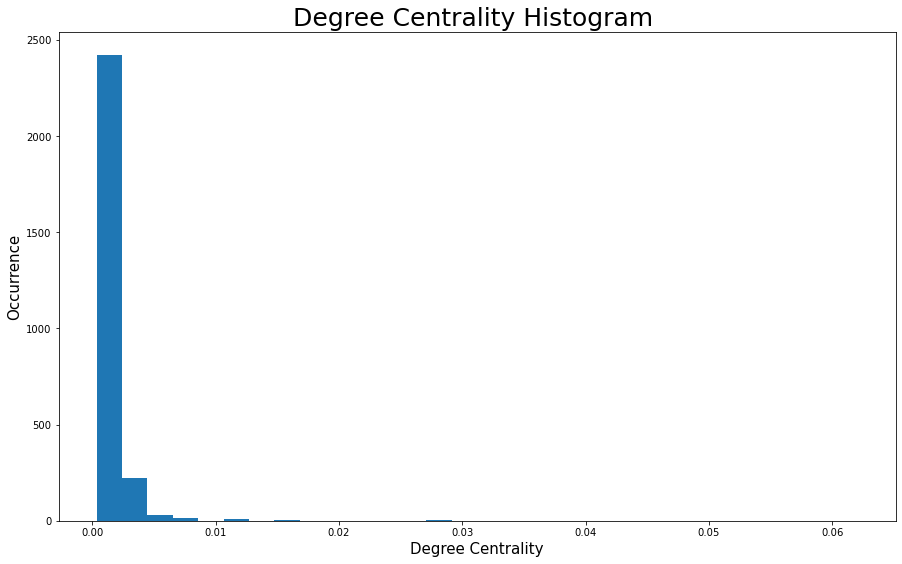

In [16]:
plt.subplots(figsize=(15, 9))
plt.hist(degree.values(), bins=30)
plt.title("Degree Centrality Histogram ", fontdict={"size": 25}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 15})
plt.ylabel("Occurrence", fontdict={"size": 15})

### 2.Eigenvector centrality

In [17]:
eig = nx.centrality.eigenvector_centrality(G)  
eig_10 = (sorted(degree.items(), key=lambda x: x[1], reverse=True))[:10]
print("Max 10:\n", eig_10)

Max 10:
 [(35, 0.062061322497229406), (6213, 0.028814185445142224), (1365, 0.027336534909493903), (3229, 0.024011821204285185), (910, 0.01625415589213151), (114, 0.015515330624307351), (4330, 0.014776505356483192), (3231, 0.013298854820834873), (1272, 0.012560029553010712), (19621, 0.012190616919098634)]


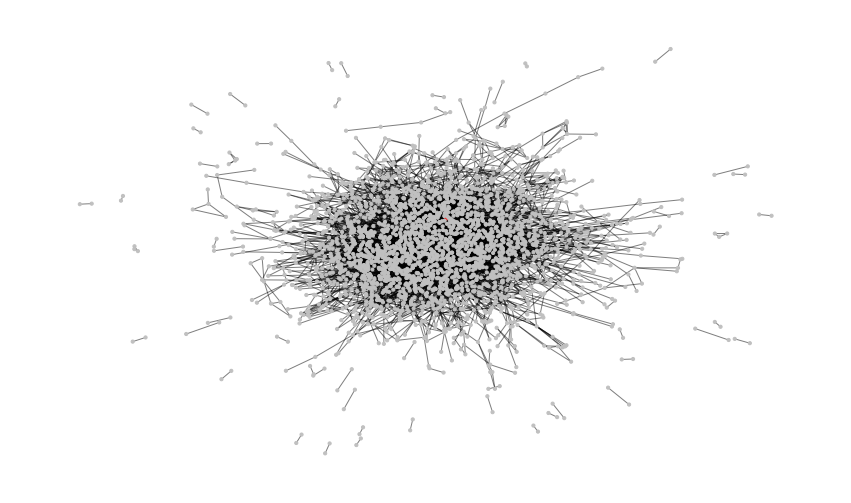

In [18]:
# 可视化
max_eig = max(np.max(eig.values()))
highlight = []
nodes_size = []
for key, value in eig.items():
    if value > max_eig*0.75:
        highlight.append('red')
        nodes_size.append(10) # 由于eig值大的点比较聚集，因此不用突出显示
    elif value > max_eig*0.5:
        highlight.append("orange")
        nodes_size.append(10)
    elif value > max_eig*0.25:
        highlight.append('yellow')
        nodes_size.append(10)
    else:
        highlight.append("Silver")
        nodes_size.append(10)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size = nodes_size, node_color = highlight)
nx.draw_networkx_edges(G, pos=pos, alpha = alpha)    

Text(0, 0.5, 'Occurrence')

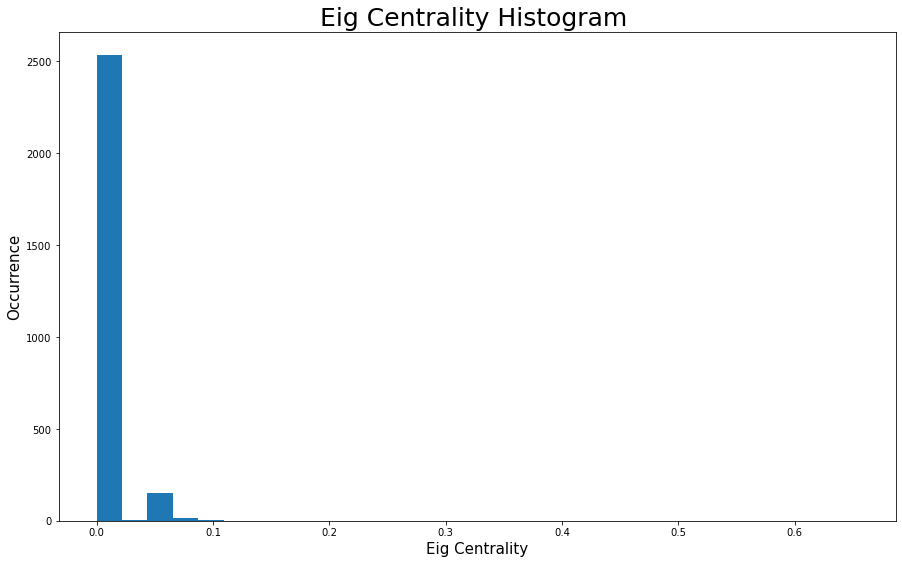

In [19]:
plt.subplots(figsize=(15, 9))
plt.hist(eig.values(), bins=30)
plt.title("Eig Centrality Histogram ", fontdict={"size": 25}, loc="center")
plt.xlabel("Eig Centrality", fontdict={"size": 15})
plt.ylabel("Occurrence", fontdict={"size": 15})

### 3.Katz Centrality

In [20]:
katz = nx.centrality.degree_centrality(G)  
katz_10 = (sorted(katz.items(), key=lambda x: x[1], reverse=True))[:10]
print("Max 10:\n", katz_10)

Max 10:
 [(35, 0.062061322497229406), (6213, 0.028814185445142224), (1365, 0.027336534909493903), (3229, 0.024011821204285185), (910, 0.01625415589213151), (114, 0.015515330624307351), (4330, 0.014776505356483192), (3231, 0.013298854820834873), (1272, 0.012560029553010712), (19621, 0.012190616919098634)]


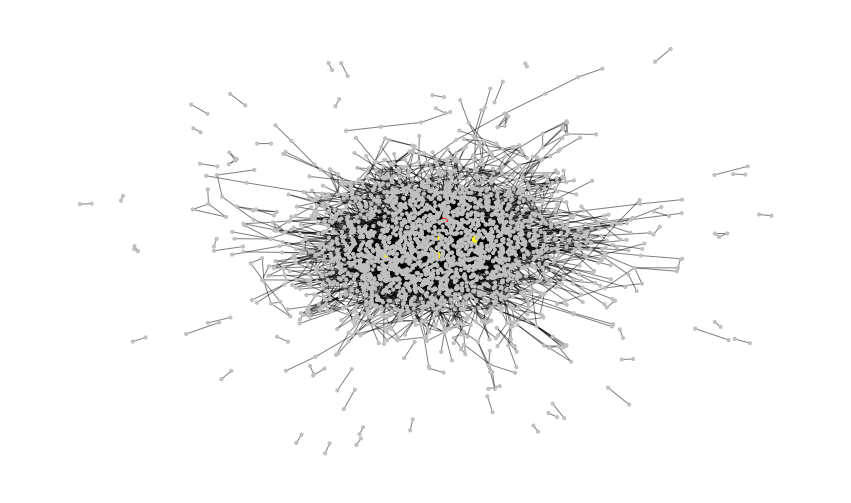

In [21]:
# 可视化
max_katz = max(np.max(katz.values()))
highlight = []
nodes_size = []
for key, value in katz.items():
    if value > max_katz*0.75:
        highlight.append('red')
        nodes_size.append(50) 
    elif value > max_katz*0.5:
        highlight.append("orange")
        nodes_size.append(40)
    elif value > max_katz*0.25:
        highlight.append('yellow')
        nodes_size.append(30)
    else:
        highlight.append("Silver")
        nodes_size.append(10)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size = nodes_size, node_color = highlight)
nx.draw_networkx_edges(G, pos=pos, alpha = alpha)    

Text(0, 0.5, 'Occurrence')

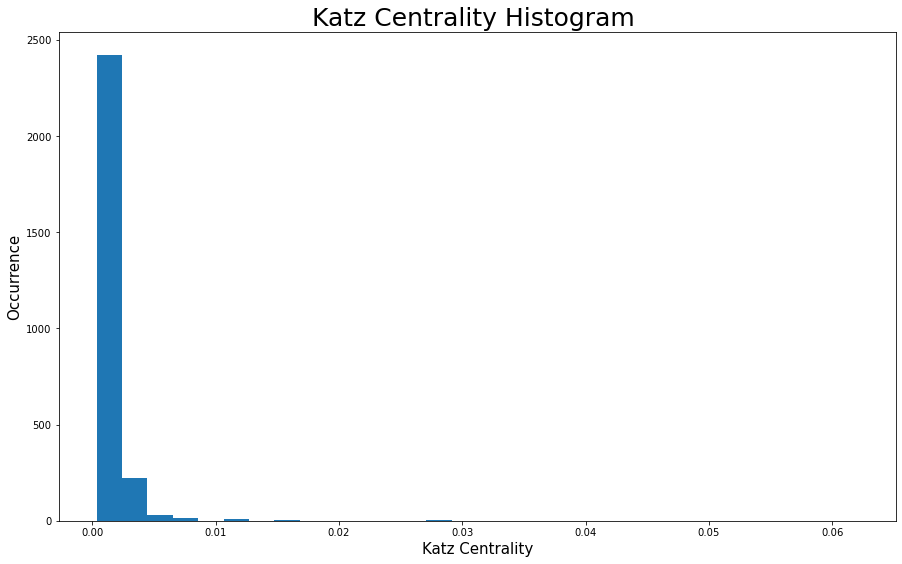

In [22]:
plt.subplots(figsize=(15, 9))
plt.hist(katz.values(), bins=30)
plt.title("Katz Centrality Histogram ", fontdict={"size": 25}, loc="center")
plt.xlabel("Katz Centrality", fontdict={"size": 15})
plt.ylabel("Occurrence", fontdict={"size": 15})

### 4. PageRank Centrality

In [23]:
page = nx.pagerank(G, alpha=0.8)  
page_10 = (sorted(page.items(), key=lambda x: x[1], reverse=True))[:10]
print("Max 10:\n", page_10)

Max 10:
 [(35, 0.011520557223268448), (1365, 0.006021464253226289), (3229, 0.005087143775885368), (6213, 0.004718850655908917), (910, 0.003463457682357944), (4330, 0.0030270599305389245), (114, 0.0026340678641991397), (3231, 0.0025279780806963764), (19621, 0.002494722905240077), (1272, 0.002397755338172252)]


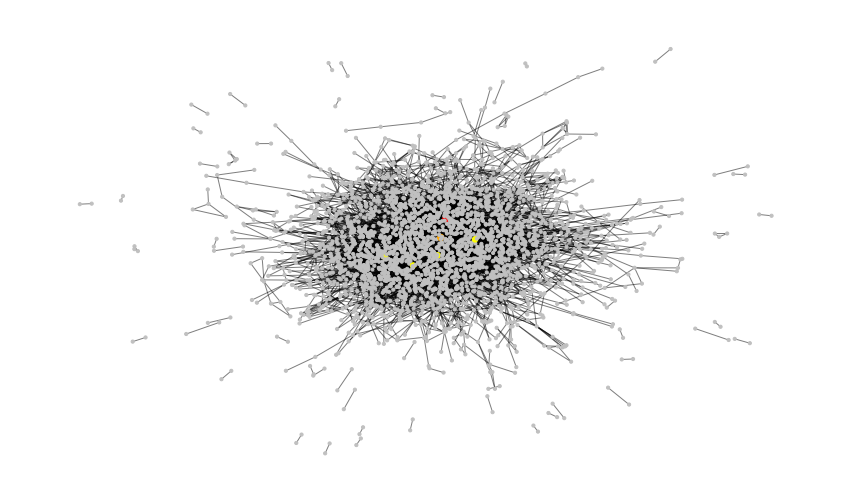

In [24]:
# 可视化
max_page = max(np.max(page.values()))
highlight = []
nodes_size = []
for key, value in page.items():
    if value > max_page*0.75:
        highlight.append('red')
        nodes_size.append(50) 
    elif value > max_page*0.5:
        highlight.append("orange")
        nodes_size.append(40)
    elif value > max_page*0.25:
        highlight.append('yellow')
        nodes_size.append(30)
    else:
        highlight.append("Silver")
        nodes_size.append(10)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size = nodes_size, node_color = highlight)
nx.draw_networkx_edges(G, pos=pos, alpha = alpha)  

Text(0, 0.5, 'Occurrence')

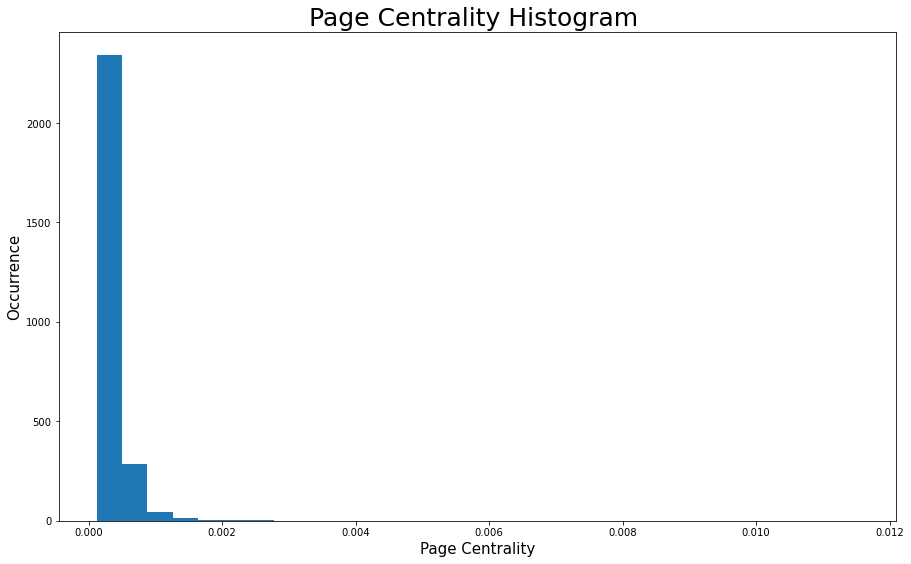

In [25]:
plt.subplots(figsize=(15, 9))
plt.hist(page.values(), bins=30)
plt.title("Page Centrality Histogram ", fontdict={"size": 25}, loc="center")
plt.xlabel("Page Centrality", fontdict={"size": 15})
plt.ylabel("Occurrence", fontdict={"size": 15})

### 5. Betweenness Centrality

In [26]:
between = nx.centrality.betweenness_centrality(G)  
between_10 = (sorted(between.items(), key=lambda x: x[1], reverse=True))[:10]
print("Max 10:\n", between_10)

Max 10:
 [(35, 0.23248831450559274), (3229, 0.12610085690638292), (4330, 0.08934413819511756), (1365, 0.08534091150396639), (6213, 0.07637499735733924), (887, 0.067917639987497), (1272, 0.06318672100688451), (910, 0.05248877225435383), (3231, 0.04984250020738586), (6214, 0.04125043108324375)]


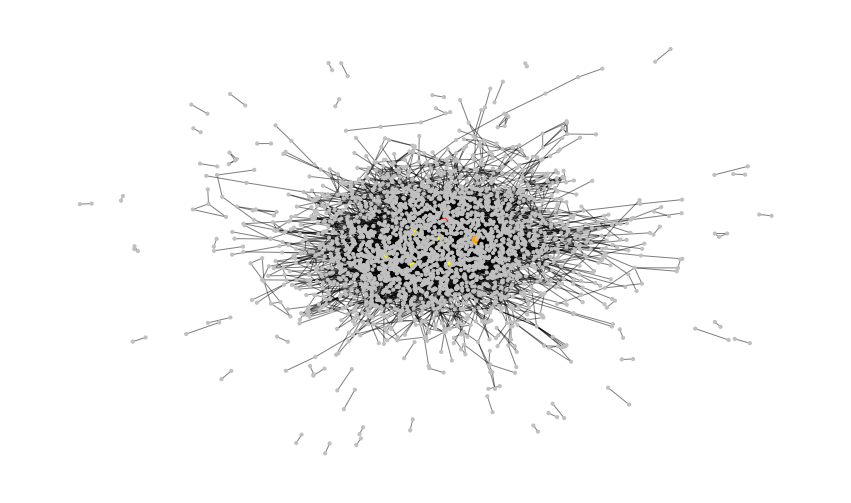

In [27]:
# 可视化
max_between = max(np.max(between.values()))
highlight = []
nodes_size = []
for key, value in between.items():
    if value > max_between*0.75:
        highlight.append('red')
        nodes_size.append(50) 
    elif value > max_between*0.5:
        highlight.append("orange")
        nodes_size.append(40)
    elif value > max_between*0.25:
        highlight.append('yellow')
        nodes_size.append(30)
    else:
        highlight.append("Silver")
        nodes_size.append(10)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size = nodes_size, node_color = highlight)
nx.draw_networkx_edges(G, pos=pos, alpha = alpha)  

Text(0, 0.5, 'Occurrence')

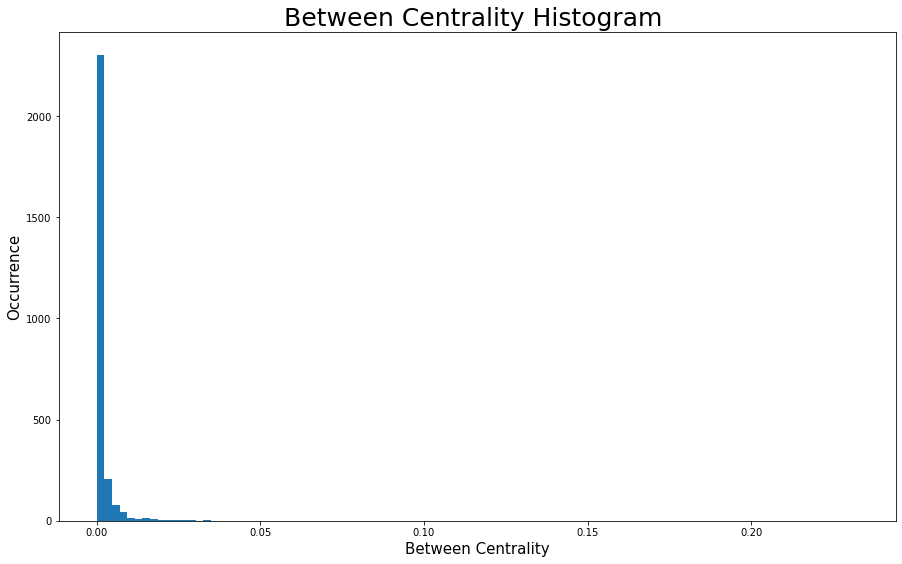

In [28]:
plt.subplots(figsize=(15, 9))
plt.hist(between.values(), bins=100)
plt.title("Between Centrality Histogram ", fontdict={"size": 25}, loc="center")
plt.xlabel("Between Centrality", fontdict={"size": 15})
plt.ylabel("Occurrence", fontdict={"size": 15})

### 6. Closeness centrality

In [29]:
close = nx.centrality.closeness_centrality(G)  
close_10 = (sorted(close.items(), key=lambda x: x[1], reverse=True))[:10]
print("Max 10:\n", close_10)

Max 10:
 [(35, 0.22276881556604902), (6213, 0.2211907346794579), (3229, 0.21982549145258112), (887, 0.21601312745183981), (4584, 0.21595173101580423), (6214, 0.21338424647742124), (1272, 0.21244948465577534), (6184, 0.20884831600438095), (4330, 0.20763076342428619), (1050679, 0.20734745027488527)]


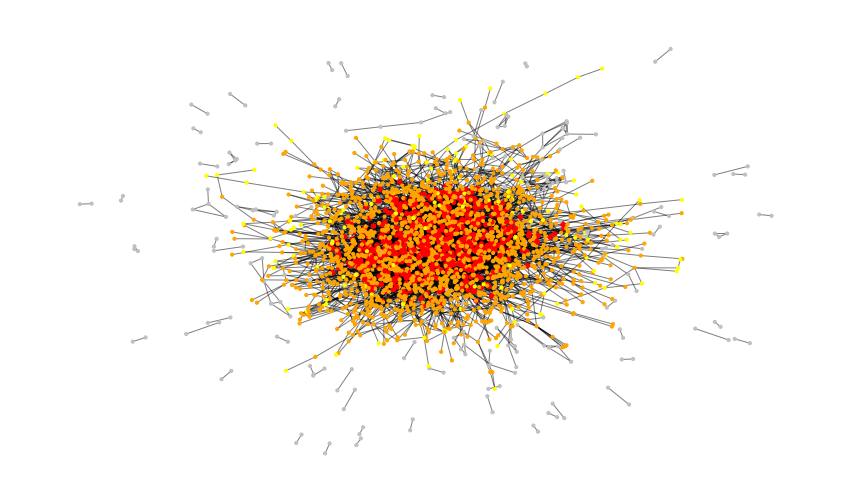

In [30]:
# 可视化
max_close = max(np.max(close.values()))
highlight = []
nodes_size = []
for key, value in close.items():
    if value > max_close*0.75:
        highlight.append('red')
        nodes_size.append(20) 
    elif value > max_close*0.5:
        highlight.append("orange")
        nodes_size.append(10)
    elif value > max_close*0.25:
        highlight.append('yellow')
        nodes_size.append(10)
    else:
        highlight.append("Silver")
        nodes_size.append(10)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size = nodes_size, node_color = highlight)
nx.draw_networkx_edges(G, pos=pos, alpha = alpha)  

Text(0, 0.5, 'Occurrence')

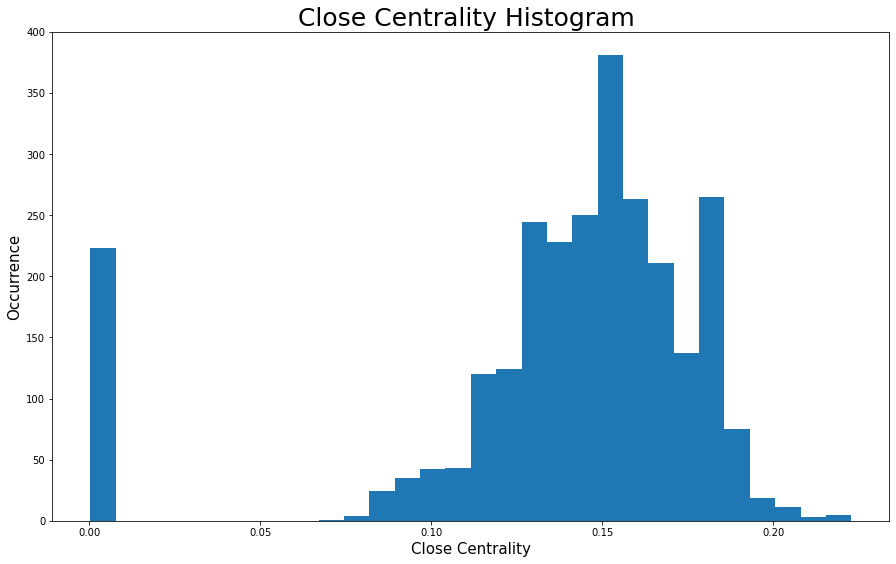

In [31]:
plt.subplots(figsize=(15, 9))
plt.hist(close.values(), bins=30)
plt.title("Close Centrality Histogram ", fontdict={"size": 25}, loc="center")
plt.xlabel("Close Centrality", fontdict={"size": 15})
plt.ylabel("Occurrence", fontdict={"size": 15})